In [5]:
import numpy as np
import math
import prune
import os
import matplotlib.pyplot as plt
from datetime import datetime
from tqdm import tqdm
os.environ["OMP_NUM_THREADS"] = "1"

mp = prune.ModelPruner('resnet18','MNIST', 'by_channel')
print(mp.baseline)

Load model: ./model_weights/resnet18_MNIST.pt...
{'loss': 0.02684426321648061, 'acc': 99.375}


In [6]:
#this is the phony generator
def generator(in_arr):
    pruned_model = mp.prune_model(in_arr)
    return mp.get_fitness_score(pruned_model)

def One_fifth_single_pass(decision_len, deci_arr_in, stepsize_in):
    random_normal_i = np.random.normal(0, 1, size=(decision_len))
    # random_normal = np.random.normal(0, 1, size=(1))
    
    #store input variable
    deci_arr = np.copy(deci_arr_in)
    stepsize = np.copy(stepsize_in)
    
    for i in range(decision_len):

        deci_arr[i] += stepsize*random_normal_i[i]
        if(deci_arr[i] <= 0.001):
            deci_arr[i] = 0.001
        elif(deci_arr[i] >= 1):
            deci_arr[i] = 0.999

    return deci_arr


def ESXPlusX_OneFifth(  Decision_var_record, Stepsize_record, Best_score_record, PS_record,
                        Decision_arr_init, Stepsize_init, Ggenerations, hp_a_param, Best_acc_record,
                        Target_run):
    train_runs = 0
    
    decision_var_arr = np.copy(Decision_arr_init)
    stepsize = Stepsize_init
    
    best_score, best_acc = generator(decision_var_arr)

    while(train_runs < Target_run):
        print(f'Training epoch: {train_runs+1}/{Target_run}')
        # memorize_parent_decision_var_arr = np.copy(decision_var_arr)
        # memorize_parent_stepsize = stepsize

        evolve_kids = 0
        for run in range(Ggenerations):

            tmp_decision_var_arr = One_fifth_single_pass(len(Decision_arr_init),decision_var_arr,stepsize)
            tmp_score, tmp_acc = generator(tmp_decision_var_arr)


            if(tmp_score < best_score):
                evolve_kids+=1
                best_score = tmp_score
                best_acc = tmp_acc
                decision_var_arr = np.copy(tmp_decision_var_arr)
                
        if(evolve_kids > (Ggenerations/5)):
            stepsize = stepsize/hp_a_param
        elif(evolve_kids < (Ggenerations/5)):
            stepsize = stepsize*hp_a_param
        
        Decision_var_record.append(decision_var_arr)
        Stepsize_record.append(float(stepsize))
        Best_score_record.append(best_score)
        Best_acc_record.append(best_acc)
        PS_record.append(evolve_kids/Ggenerations)
        train_runs+=1

    return decision_var_arr, stepsize, best_score


In [7]:
# Hyperparameters could be change here:

# Self adaptation of step-size: 1/5 Rule
# It runs for a certain amount of runs with fix stepsize, and determine if the 1/5 
# results are better than the parent generation.
# if yes, stepsize /= a
# else stepsize *= a


HP_DECISION_INITVAL = 0.5   # Initial value for decision variable
HP_STEPSIZE_INITVAL = 0.1   # Initial value for stepsize
HP_GGENERATIONS = 15        # Run how many runs before updating the step size
HP_A = 0.817                # a magical value to update step size, repordely 0.817 <= a <= 1
HP_ITERATIONS = 5           # Run how many runs, the total pruning is HP_GGENERATIONS*HP_ITERATIONS


#auto generated param(Don't change)
Decision_arr = np.array([HP_DECISION_INITVAL for i in range(mp.prunable_layer_num)]) 
DV_record = []
SZ_record = []
BS_reocrd = []
BA_record = []
PS_record = []

ans_decvar, ans_stepsize, ans_bestscore = ESXPlusX_OneFifth(Decision_var_record=DV_record,Stepsize_record=SZ_record,Best_score_record=BS_reocrd, PS_record=PS_record,
            Decision_arr_init=Decision_arr,Stepsize_init=HP_STEPSIZE_INITVAL, Best_acc_record=BA_record,
            Ggenerations=HP_GGENERATIONS, hp_a_param=HP_A, Target_run=HP_ITERATIONS)


print(DV_record)
print(SZ_record)
print(BS_reocrd)
print(BA_record)
print(PS_record)

Training epoch: 1/5
Training epoch: 2/5
Training epoch: 3/5
Training epoch: 4/5
Training epoch: 5/5
[array([0.70494439, 0.8152713 , 0.46407077, 0.001     , 0.69876352,
       0.53530906, 0.84634465, 0.48905006, 0.3255774 , 0.89086085,
       0.52355298, 0.71288902, 0.60614644, 0.53432443, 0.39702243,
       0.31579949, 0.3758858 , 0.2519628 , 0.40083537, 0.07856583]), array([0.71711355, 0.999     , 0.163728  , 0.09335388, 0.84142827,
       0.59993082, 0.999     , 0.60830864, 0.38198182, 0.68848473,
       0.44295065, 0.999     , 0.98761776, 0.75869471, 0.8687596 ,
       0.92163389, 0.001     , 0.001     , 0.01346118, 0.05413918]), array([0.75002908, 0.999     , 0.23547554, 0.28212998, 0.91746378,
       0.52579984, 0.86643002, 0.64068381, 0.25320397, 0.5824854 ,
       0.48922788, 0.999     , 0.999     , 0.80113025, 0.95112992,
       0.92589274, 0.001     , 0.001     , 0.001     , 0.001     ]), array([0.75002908, 0.999     , 0.23547554, 0.28212998, 0.91746378,
       0.52579984, 0.8

OSError: [Errno 22] Invalid argument: './image_output/VGG11OneFifthEC_5runs_2022-12-15 22:40:28.png'

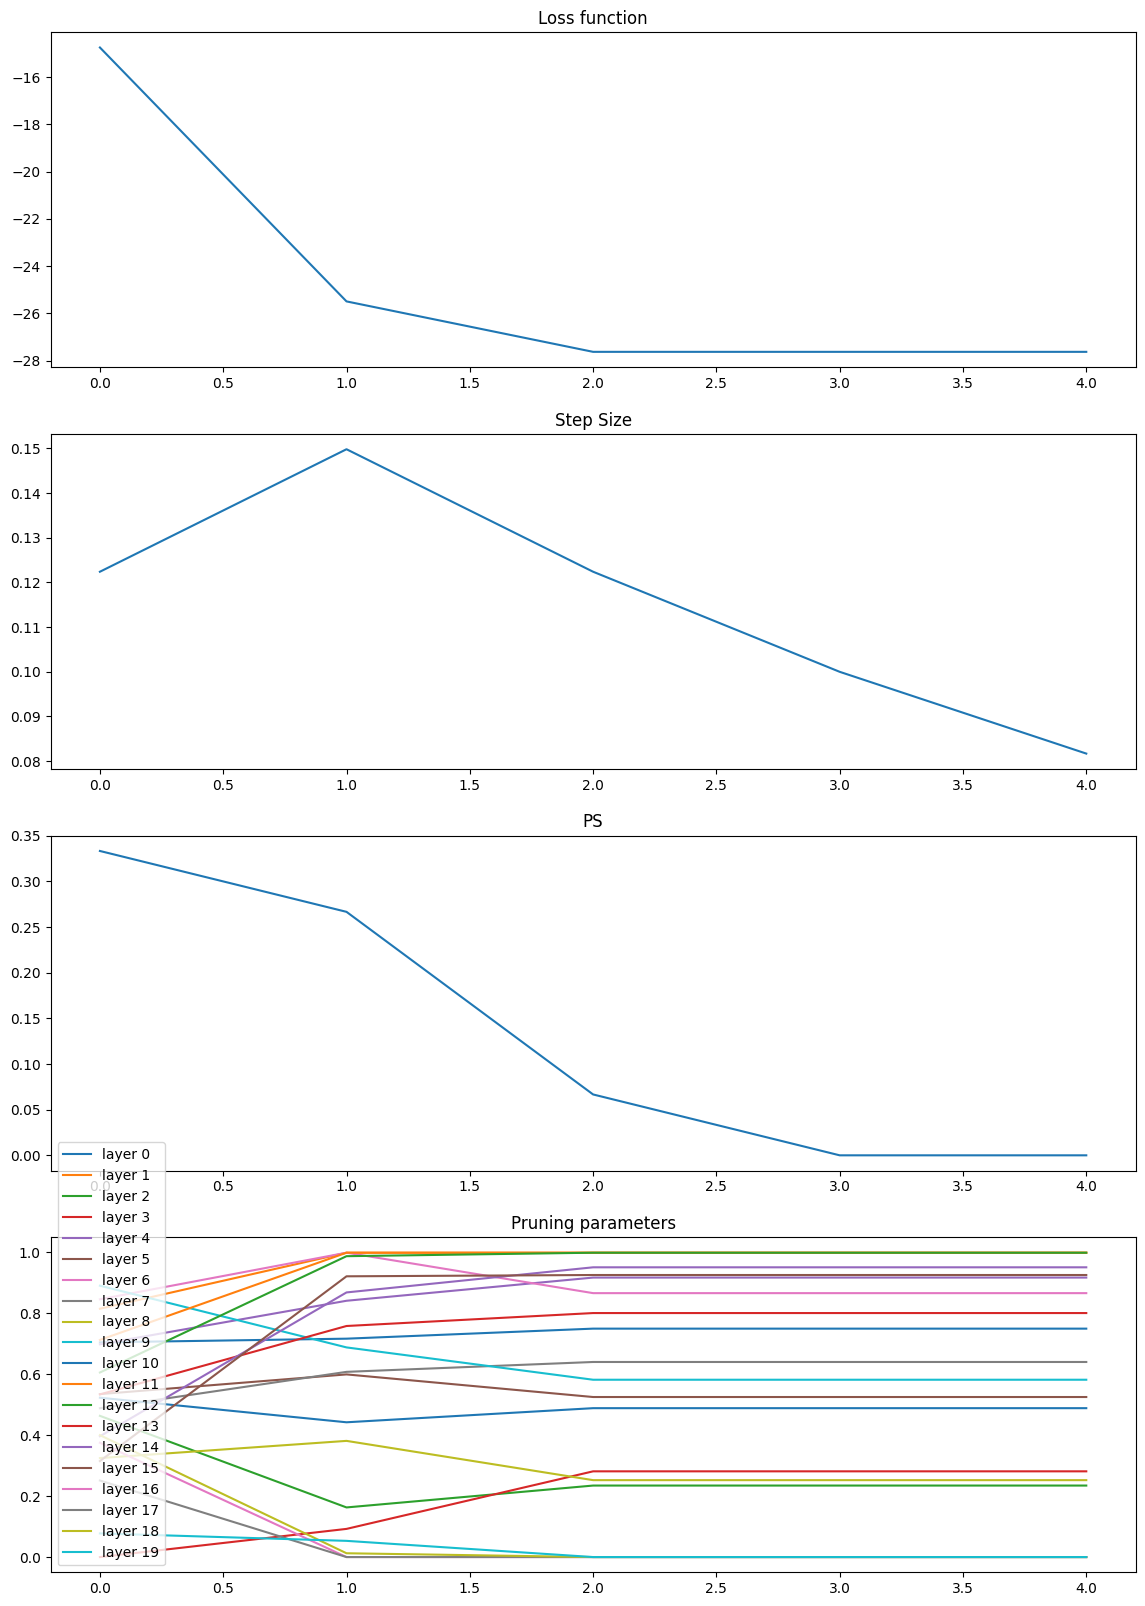

In [8]:
def plotOFResult(arr1, arr2,arr3, arr2d, model_name):
    run_num = len(arr1)
    parm_num = len(arr2d[0])
    plt.figure(figsize=(14,20))
    
    ax1 = plt.subplot(411)
    ax1.plot(arr1)
    ax1.set_title('Loss function')

    ax2 = plt.subplot(412)
    ax2.plot(arr2)
    ax2.set_title('Step Size')

    ax2 = plt.subplot(413)
    ax2.plot(arr3)
    ax2.set_title('PS')

    ax3 = plt.subplot(414)
    for line in range(parm_num):
        ax3.plot([arr2d[j][line] for j in range(run_num)], label = f'layer {line}')

    ax3.set_title('Pruning parameters')    
    ax3.legend(loc=3)   

    now=datetime.now()
    time_print=now.strftime("%Y-%m-%d %H:%M:%S")
    plt.savefig(f'./image_output/{model_name}OneFifthEC_{run_num}runs_{time_print}.png',dpi = 400)
    plt.show()
    

plotOFResult(BS_reocrd,SZ_record,PS_record,DV_record,"VGG11")

